## FLUORESCENCE OF A TWO-LEVEL ATOM

In [27]:
using QuantumOptics 
using CairoMakie 
using Plots
using LaTeXStrings
using LinearAlgebra
using GLMakie
using FFTW


import Plots as P
colors=P.palette(:tab10)

Consider a two-level atom with ground state |g⟩ and excited state |e⟩ driven by a coherent laser field. The Hamiltonian of the two-level atom is 
$\begin{equation}
H=-\frac{\delta}{2}\sigma_z + \frac{\Omega}{2}(\sigma_+ + \sigma_-),
\end{equation}$
where we consider $\hbar = 1$ for computional purpose.
With Markovian dissipation accounting for spontaneous emission $\Gamma_e$, the dynamics of the system is governed by the Lindblad master equation
$\begin{equation}
\frac{d\rho_S}{dt} = -\frac{i}{\hbar}[H, \rho_S] + \Gamma_e \left( \sigma_- \rho_S \sigma_+ - \frac{1}{2} \left\{ \sigma_+ \sigma_-, \rho_S \right\} \right).
\end{equation}$

At non-zero temperature, one should replace the dissipative term in Eq. (2) by
$\begin{equation}
\Gamma_e(\bar{n}+1)\left(\sigma_{-}\rho\sigma_{+} - \frac{1}{2} \left\{ \sigma_{+}\sigma_{-}, \rho \right\} \right)+
 \Gamma_e \bar{n} \left(\sigma_{+}\rho\sigma_{-} - \frac{1}{2} \left\{ \sigma_{-}\sigma_{+}, \rho \right\} \right),
\end{equation}$
where $\bar{n} = \left(e^{\hbar \omega_0 / k_B T} - 1\right)^{-1}$  is the mean number of thermal photons of energy $\hbar\omega_0$ at temperature $T$.
When the atom also undergoes pure dephasing at a rate  $\Gamma_d$, the following term must be added to the master
 equation :
$\begin{equation}
\Gamma_d \left( \sigma_z \rho \sigma_z - \frac{1}{2} \left\{ \sigma_z \sigma_z, \rho \right\} \right).
\end{equation}$



Parameters :

In [ ]:
ω0 = 1                  #Transition frequency between |e> and |g>
ωL = 1                  #Frequency of the Laser
δ = ωL - ω0             #Detuning
Ωs = [0,0.1,0.5,1,5,10] #List of Rabi frequencies
Γe = 1                  #Spontaneous emission rate
Γd = 0                  #Dephasing rate
T = 0;                  #Temperature

0

System :

In [29]:
#System 
b = NLevelBasis(2)
σ_z = transition(b,2,2)-transition(b,1,1)
σ_p = transition(b,2,1)
σ_m = transition(b,1,2)

#Hamiltonian
h(δ,Ω) = -δ/2*σ_z + Ω/2*(σ_p + σ_m) 

#Evolution
tspan = 0:0.05:10
rates = [Γe]
J = [σ_m]

#Spontaneous emission rate depending on T
if T > 0
    n = 1/(exp(ω0/T) - 1)
    rates = [Γe * (n + 1), Γe * n]
    J = [σ_m, σ_p]
end

#Dephasing
if Γd > 0
  push!(rates,Γd)
  push!(J,σ_z)
end;

#Initial state
ψ0 = nlevelstate(b,2)   
ψ0 = tensor(ψ0,ψ0'); 

0) Evolution of the excited state population depending on time, for different values of $\frac{\Omega}{\Gamma_e}$.

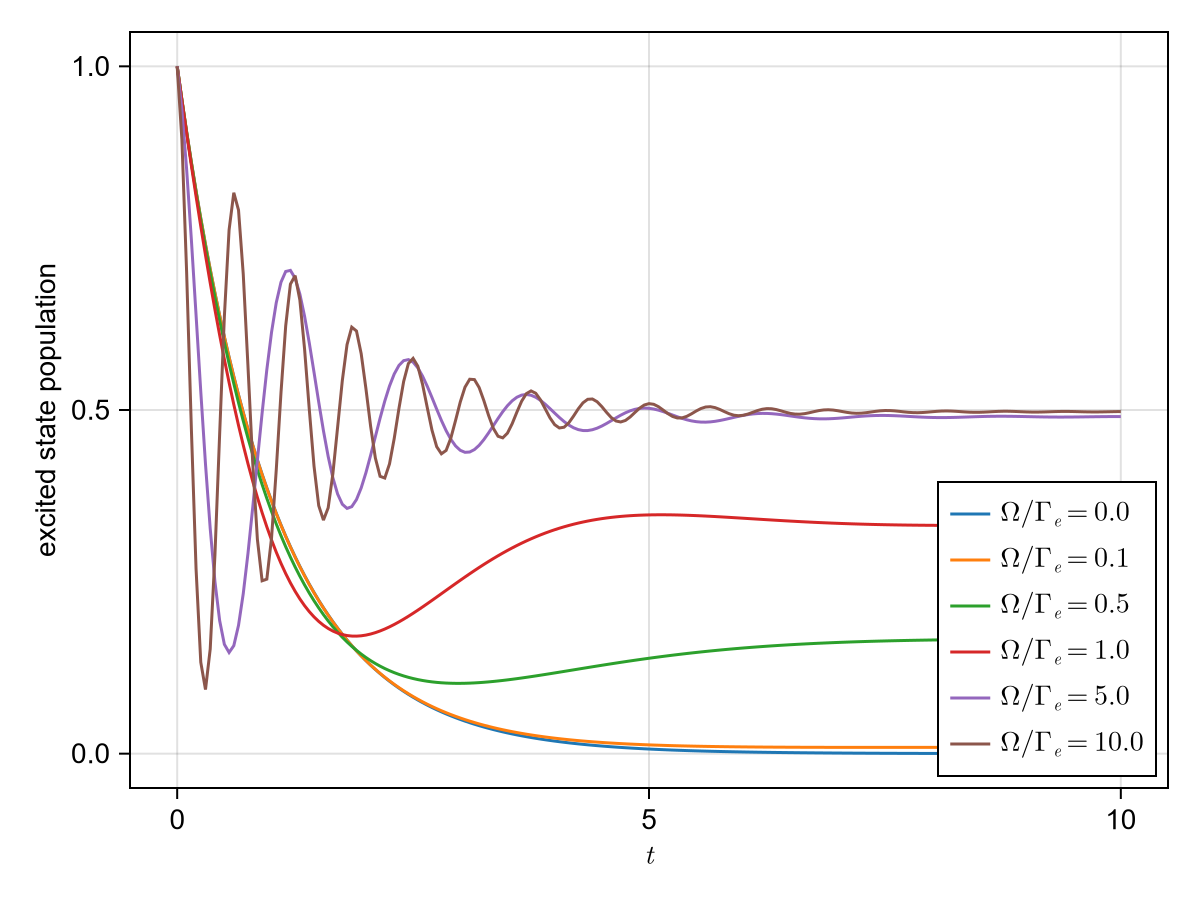

In [30]:
#Figure
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"t", ylabel="excited state population")

for (i,Ω) in enumerate(Ωs)
    #time evolution
    tout, ψt=timeevolution.master(tspan,ψ0,h(δ, Ω),J; rates)
    #expectation value
    exp_pt=real(expect(transition(b,2,2),ψt))
    #plotting
    lines!(ax, tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end
axislegend(ax,position=:rb)

fig

1) Let's find the steady state $\rho_{ss}$ of equation (2), and represent it in the Bloch ball representation.

Bloch vector norm positions for different values of Ω/Γ_e :
-----------------------------------------------------
|λ| = 0.999999999999999 for Ω/Γe = 0.0
|λ| = 0.999807747763291 for Ω/Γe = 0.1
|λ| = 0.9428090415820631 for Ω/Γe = 0.5
|λ| = 0.7453559924999296 for Ω/Γe = 1.0
|λ| = 0.1970563847278609 for Ω/Γe = 5.0
|λ| = 0.09962678803234207 for Ω/Γe = 10.0


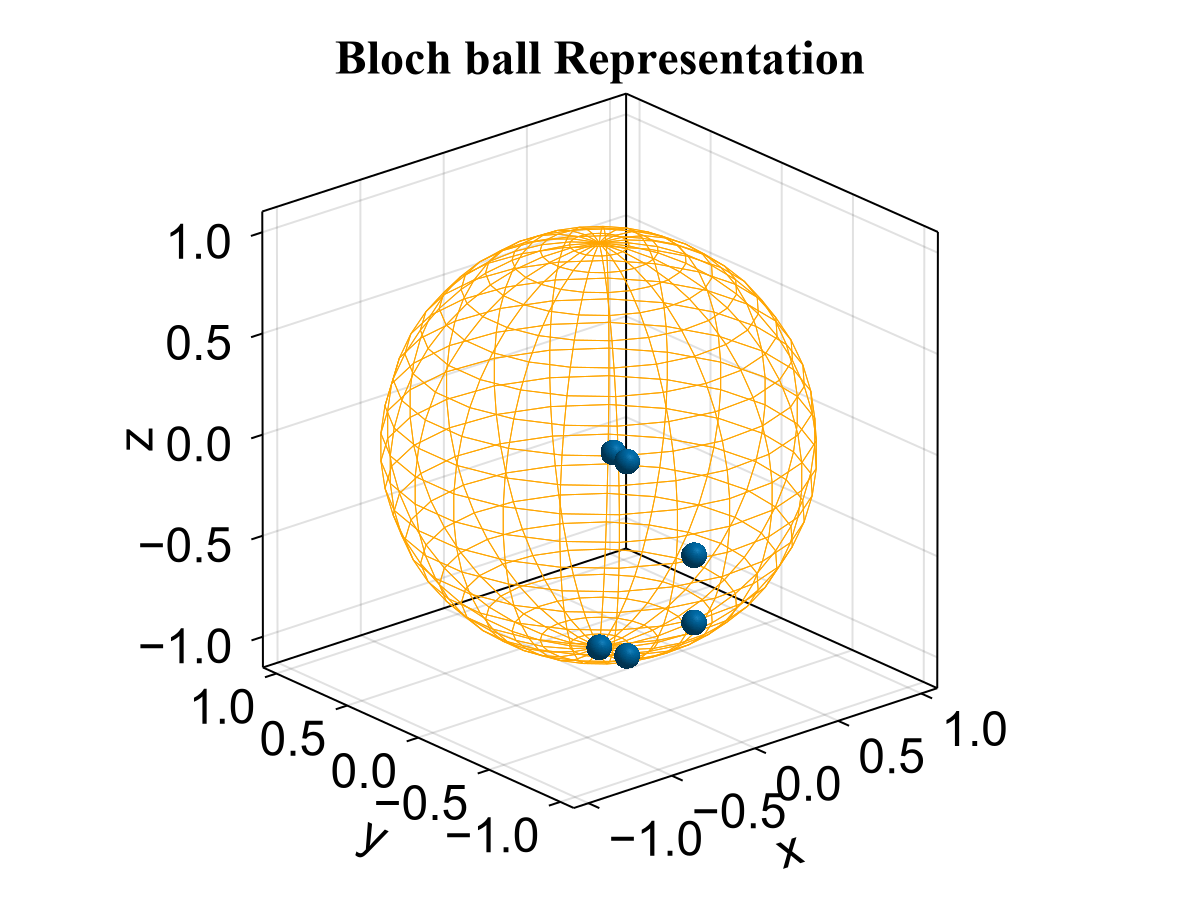

In [31]:
#Pauli matrices
σ_x = transition(b,1,2)+transition(b,2,1)
σ_y = im*(transition(b,2,1)-transition(b,1,2))
paulis = [σ_x, σ_y, σ_z]

#Vector to save the position of the Bloch vector
positions = Vector{Vector{Float64}}()
println("Bloch vector norm positions for different values of Ω/Γ_e :")
println("-----------------------------------------------------")
#Steady state 
for (i,Ω) in enumerate(Ωs)
ρ_ss = steadystate.eigenvector(h(δ,Ω), J; rates = rates)
λ = [real(tr(ρ_ss * σ)) for σ in paulis]
println("|λ| = ", norm(λ)," for Ω/Γe = ",Ω/Γe)
push!(positions,λ)
end

#use this command if you want an interactive figure
#GLMakie.activate!()

#Figure
set_theme!(fonts = ( ; regular = "Arial", bold = "Times New Roman Bold"))
x = [p[1] for p in positions]
y = [p[2] for p in positions]
z = [p[3] for p in positions]
figure = Figure(fontsize=24)
axis = Axis3(figure[1, 1], aspect = :data, title="Bloch ball Representation")
#hidedecorations!(axis)
#hidespines!(axis)
sphere = GLMakie.Sphere(Point3f(0), 1)
GLMakie.wireframe!(axis,sphere; linewidth=0.5, color=:orange)
meshscatter!(axis,x,y,z, markersize=0.05)

figure

2) Two-time correlation function $\langle \sigma_+(\tau)\sigma_-(0)\rangle$.


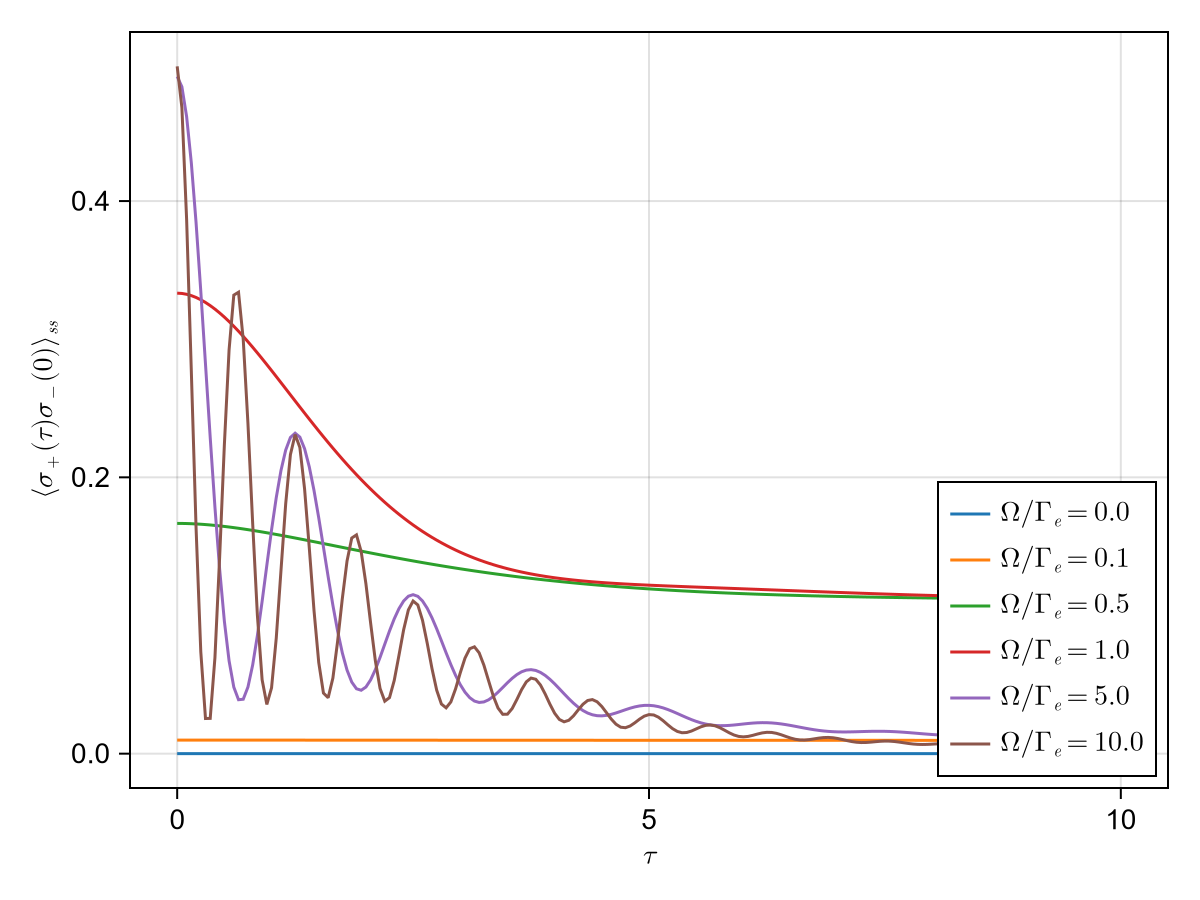

In [32]:
τs = 0:0.05:10 #List of τ

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}")

for (i,Ω) in enumerate(Ωs)
    ρ0 = steadystate.eigenvector(h(δ,Ω), J; rates = rates)
    corr = timecorrelations.correlation(τs, ρ0, h(δ,Ω), J, σ_p, σ_m; rates = rates)
    lines!(ax, τs, real(corr), label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

3) Calculation of the fluorescence power spectrum $S(\omega)$ in the strong field limit, when the Rabi frequency $\Omega$ is comparable or greater the the atomic decay rate $\Gamma_e$.

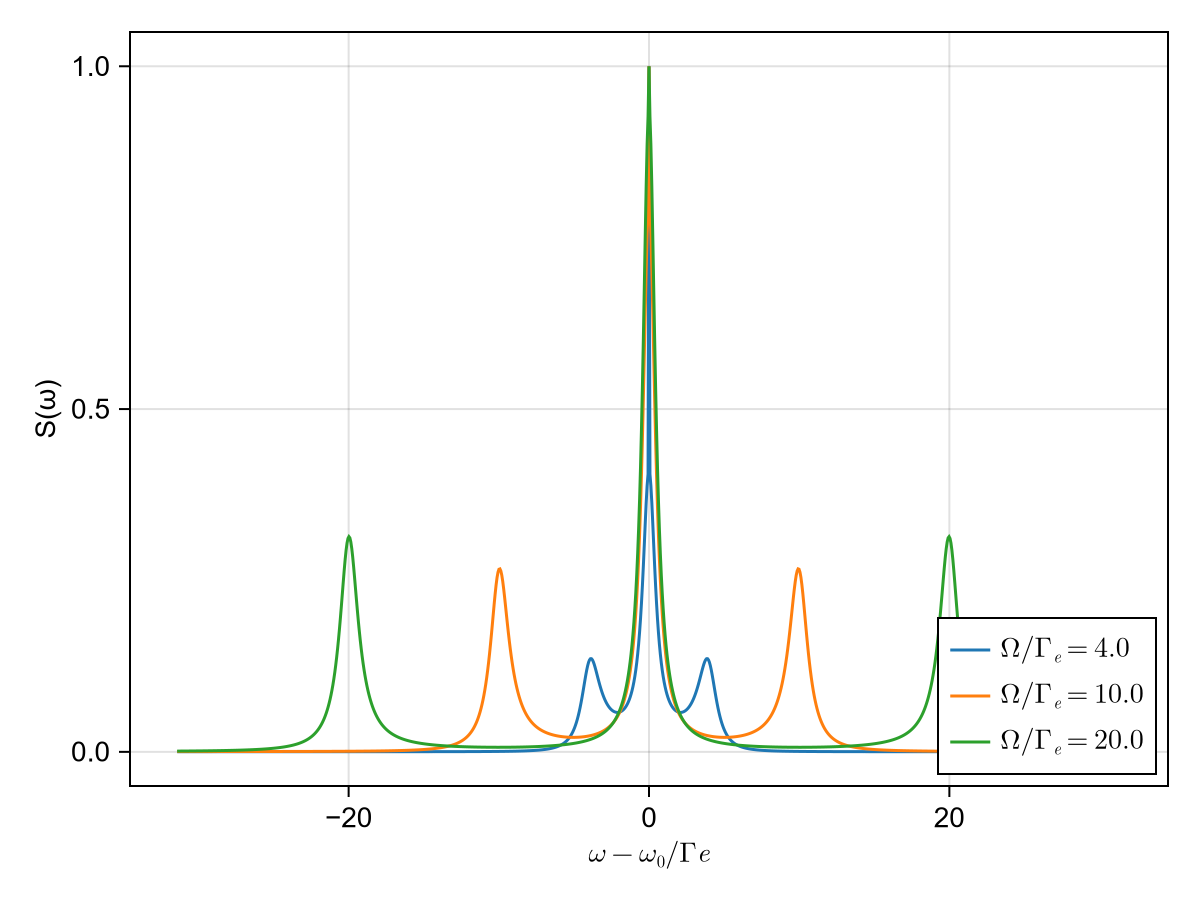

In [33]:
function fourier_transform_discrete(f_vals, t, ν)   
    dt = step(t) 
    return sum(f_vals .* exp.(-im* 2π * ν * t)) * dt
end

Ωl = [4,10,20]     #List of Rabi frequencies
νs = -5:0.01:5     #List of frequencies
τlist = 0:0.001:50 #List of τ

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\omega - \omega_0/Γe", ylabel="S(ω)")

for (i,Ω) in enumerate(Ωl)
    result=[]
    ρ0 = steadystate.eigenvector(h(δ,Ω), J; rates = rates)
    corr = timecorrelations.correlation(τlist, ρ0, h(δ,Ω), J, σ_p, σ_m; rates = rates)
    for (i,ν) in enumerate(νs)
        push!(result, fourier_transform_discrete(corr,τlist,ν))
    end
    lines!(ax,2π*νs, real(result)./maximum(real(result)), label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

4) Spectrum of the Liouvillian superoperator.

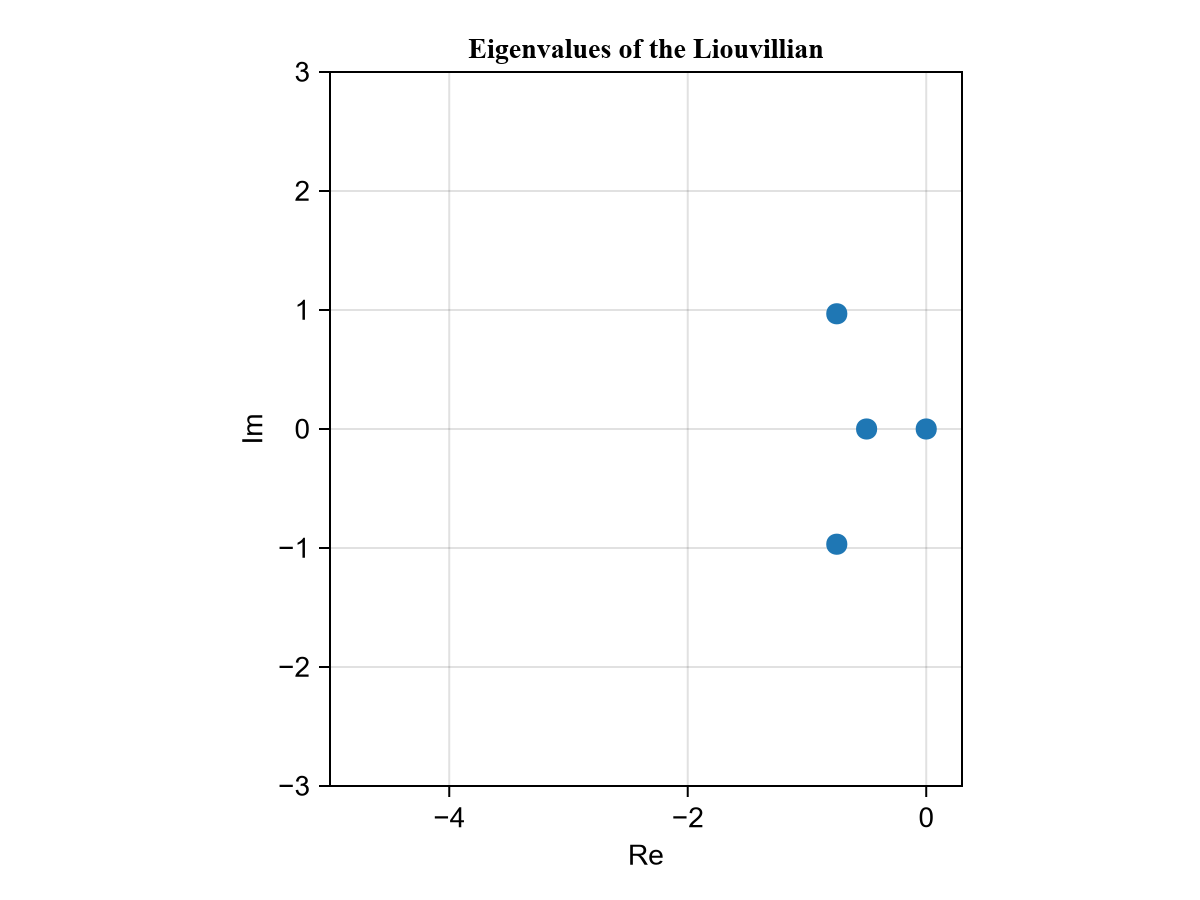

In [34]:
Ωlistt =[1] #List of Rabi frequencies

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="Re", ylabel="Im",
    title="Eigenvalues of the Liouvillian",
    xgridvisible=true, ygridvisible=true,
    aspect=DataAspect(),
)

for (i,Ω) in enumerate(Ωlistt)
L = liouvillian(h(δ,Ω),J; rates=rates) 
vals=eigen(Matrix(L.data)).values

x = real.(vals)
y = imag.(vals)

CairoMakie.scatter!(ax, x, y, markersize=15,color=colors[i])
end

CairoMakie.xlims!(ax, -5, 0.3)
CairoMakie.ylims!(ax, -3, 3)

fig

5) Computation of the characteristic relaxation times as a function of the system parameters.

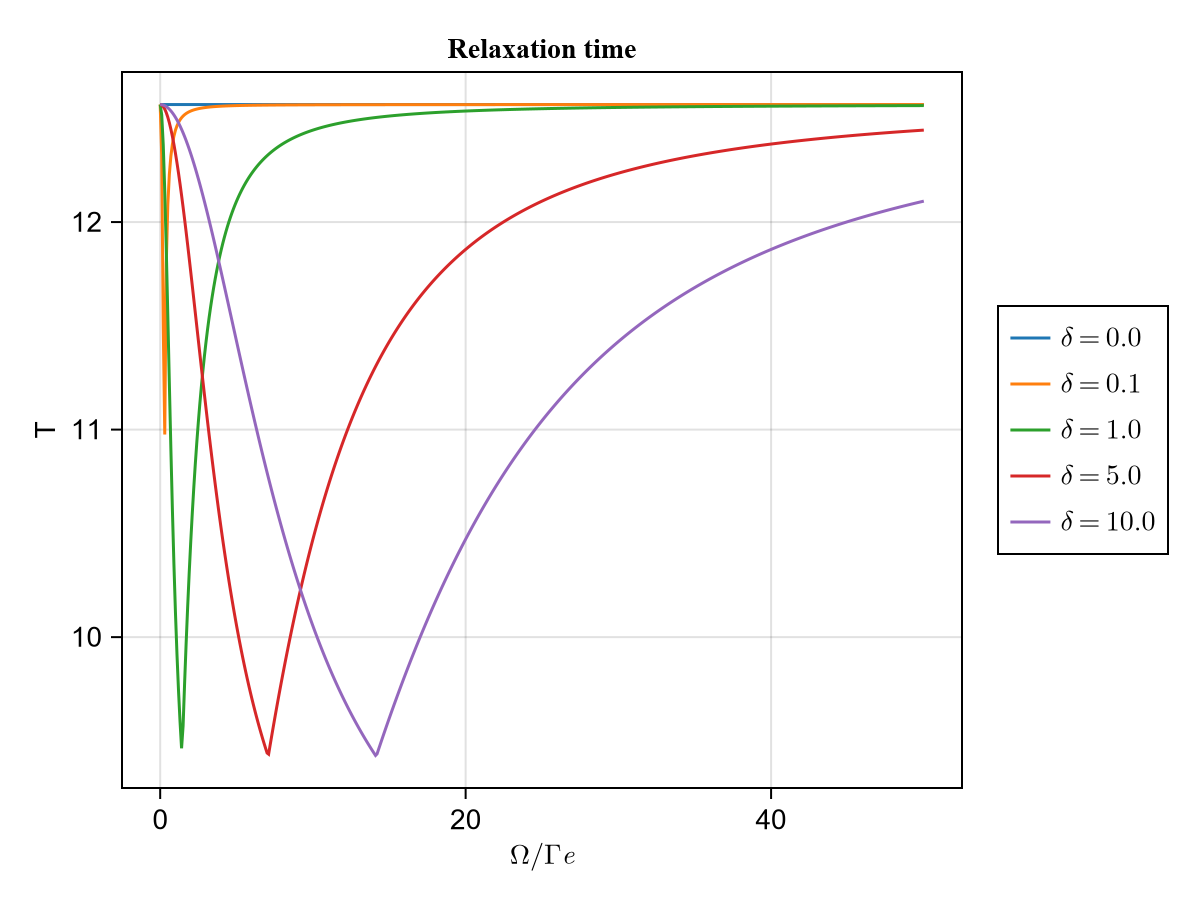

In [35]:
Ωlist = 0:0.1:50    #List of Rabi frequencies
δs = [0,0.1,1,5,10] #List of detuning

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"Ω/Γe", ylabel="T",title="Relaxation time")

for (i,δ) in enumerate(δs)
    gaplist=[]
    for (j,Ω) in enumerate(Ωlist)
        L = liouvillian(h(δ,Ω),J; rates=rates) 
        vals=eigen(Matrix(L.data)).values
        top2 = partialsort(real(vals), 1:2; rev=true)
        gap = abs(top2[1]-top2[2])
        push!(gaplist,2*π/gap)
    end
    lines!(ax, Ωlist/Γe, gaplist, label=L"\delta=%$δ",color=colors[i])
end

Legend(fig[1,2],ax)
fig
